# 

# 俄罗斯出口成绩分析
> YGL

- 数据来源:https://www.kaggle.com/datasets/pranav941/russia-to-world-trade14m-data-points
    
    含三张表:`iso3`,`partnerAreas`和`RUStoWorldTrade`
    
    ![overall](pics/2022-12-26-18-03-13.png)

    `iso`表中是各国家地区的ISO标准代码(达州,国家,首府,二字,三字,数字代码等等)
    
    `partnerareas`是主要数据表`RUStoWorldTrade`中partner字段国家的id,数据在iso中均有,因此不用

- 作者综述
    
    ![content](pics/2022-12-26-18-04-38.png)

    得出----对于主表`RUStoWorldTrade`:
    - aggregate level 列是根据`SITC`的细分专类,1-5表示层级

----


In [175]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pyecharts.charts import Bar,Scatter,Scatter3D,Boxplot,Line,Pie,HeatMap
import pyecharts.options as opts
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score

## 数据检视

In [88]:
trade_detail = pd.read_csv('./original/RUStoWorldTrade.csv')
for col in trade_detail.columns:
    if trade_detail[col].nunique()==1: 
        print(f'Column [{col}] has sole value {trade_detail[col].unique()}')
        trade_detail.drop(col,axis=1,inplace=True)

C:\Users\18631\AppData\Local\Temp\ipykernel_9568\4080473427.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  trade_detail = pd.read_csv('./original/RUStoWorldTrade.csv')


Column [Classification] has sole value ['S4']
Column [Reporter Code] has sole value [643]
Column [Reporter] has sole value ['Russian Federation']
Column [Reporter ISO] has sole value ['RUS']


- `classification`是分类标准,`S4`代表`SITC VERSION4`,见:
    https://unstats.un.org/unsd/publication/SeriesM/SeriesM_34rev4E.pdf
- `reporter`3列指的是向联合国上报的会员国的信息,所用的数据集中只有俄官方提供的,故删除

In [89]:
trade_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384603 entries, 0 to 1384602
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   index              1384603 non-null  int64  
 1   Year               1384603 non-null  int64  
 2   Aggregate Level    1384603 non-null  int64  
 3   Is Leaf Code       1384603 non-null  int64  
 4   Partner Code       1384603 non-null  int64  
 5   Partner            1384603 non-null  object 
 6   Partner ISO        1375914 non-null  object 
 7   Commodity Code     1384603 non-null  object 
 8   Commodity          1384603 non-null  object 
 9   Qty Unit Code      1384603 non-null  int64  
 10  Qty Unit           1384603 non-null  object 
 11  Qty                1283894 non-null  float64
 12  Netweight (kg)     1323567 non-null  float64
 13  Trade Value (US$)  1384603 non-null  int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 147.9+ MB


- 不清楚`is leaf code`表示的是什么
- 因此暂且使用1,2,4,5,7,9,11,13
- `trade_detail`没有高精度整数,需要减轻内存用量
- `trade_detail`保存非用户友好型数据,各code和文本解释之间的关系转为新表
- 量(`qty`)有缺省,可能是统计上的不严谨,见kaggle该数据集的问答:
    https://www.kaggle.com/datasets/pranav941/russia-to-world-trade14m-data-points/discussion/348315

In [90]:
# 将各种含code对应关系的量存为新表
trade_detail[['Qty Unit Code','Qty Unit']].drop_duplicates(ignore_index=True).to_csv('./post/Quantity.csv')
trade_detail[['Commodity Code','Commodity']].drop_duplicates(ignore_index=True).to_csv('./post/Commodity.csv')

In [91]:
print(trade_detail['Qty'].min(),trade_detail['Qty'].max())

0.0 75265886900.0


In [92]:
trade_detail.loc[trade_detail['Qty'].isna(),'Qty Unit Code'].unique()

array([1], dtype=int64)

In [93]:
trade_detail.loc[trade_detail['Qty Unit Code']==1,'Qty'].unique()

array([nan,  0.])

In [94]:
trade_detail.loc[trade_detail['Commodity Code']=='TOTAL']

,index,Year,Aggregate Level,Is Leaf Code,Partner Code,Partner,Partner ISO,Commodity Code,Commodity,Qty Unit Code,Qty Unit,Qty,Netweight (kg),Trade Value (US$)
841285,842122,2007,0,0,862,Venezuela,VEN,TOTAL,All Commodities,1,No Quantity,NaN,NaN,365400486
841286,842123,2008,0,0,862,Venezuela,VEN,TOTAL,All Commodities,1,No Quantity,NaN,NaN,957352202
841287,842124,2009,0,0,862,Venezuela,VEN,TOTAL,All Commodities,1,No Quantity,NaN,NaN,112165751
841288,842125,2010,0,0,862,Venezuela,VEN,TOTAL,All Commodities,1,No Quantity,NaN,NaN,122414614
841289,842126,2011,0,0,862,Venezuela,VEN,TOTAL,All Commodities,1,No Quantity,NaN,NaN,1705172558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989991,990869,2016,0,0,60,Bermuda,BMU,TOTAL,All Commodities,1,No Quantity,0.0,0.0,115
989992,990870,2017,0,0,60,Bermuda,BMU,TOTAL,All Commodities,1,No Quantity,0.0,0.0,4034808
989993,990871,2018,0,0,60,Bermuda,BMU,TOTAL,All Commodities,1,No Quantity,0.0,0.0,11013824
989994,990872,2019,0,0,60,Bermuda,BMU,TOTAL,All Commodities,1,No Quantity,0.0,0.0,246452


- 可知:
    - 以上,看到量`qty`为空时,计量单位为 1,即无单位
    - 对于无单位的,量只有0和空
    - commodity code 为total时指代不清,无法归类计算
- 因此:
    - 只删除`qty`的空值,其余的空值填充0
    - 删除`commodity code`为total的行

In [95]:
# 改commoditycode的total行为nan,以便删除
trade_detail.loc[trade_detail['Commodity Code']=='TOTAL','Commodity Code']=np.nan
# 去重,去空,将int精度改小
trade_detail = trade_detail.iloc[:,[1,2,4,5,7,9,11,13]].dropna(subset=['Qty','Commodity Code']).fillna(0)
for col in trade_detail.columns:
    try : 
        if trade_detail[col].dtype == 'int64':
            trade_detail[col] = trade_detail[col].astype('int16')
    except :
        trade_detail[col] = trade_detail[col].astype('float16')
#改细分类为大类
trade_detail['Commodity Code']=trade_detail['Commodity Code'].apply(lambda x : int(str(x)[0]))

trade_detail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283826 entries, 3 to 1384602
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Year               1283826 non-null  int16  
 1   Aggregate Level    1283826 non-null  int16  
 2   Partner Code       1283826 non-null  int16  
 3   Partner            1283826 non-null  object 
 4   Commodity Code     1283826 non-null  int64  
 5   Qty Unit Code      1283826 non-null  int16  
 6   Qty                1283826 non-null  float64
 7   Trade Value (US$)  1283826 non-null  int16  
dtypes: float64(1), int16(5), int64(1), object(1)
memory usage: 51.4+ MB


In [96]:
trade_detail['Commodity Code'].unique()

array([6, 8, 0, 2, 3, 4, 5, 7, 9, 1], dtype=int64)

- 添加大洲和地区进入表中

In [97]:
iso = pd.read_csv('./original/iso3.csv',usecols=["Continent","Region","ISO (3)",'ISO (No)'])
iso

,Continent,Region,ISO (3),ISO (No)
0,Asia,South Asia,AFG,4.0
1,Europe,South East Europe,ALB,8.0
2,Africa,Northern Africa,DZA,12.0
3,Oceania,Pacific,ASM,16.0
4,Europe,South West Europe,AND,20.0
...,...,...,...,...
227,Oceania,Pacific,WSM,882.0
228,Asia,South West Asia,YEM,887.0
229,Africa,Central Africa,ZAR,180.0
230,Africa,Southern Africa,ZWB,894.0


In [98]:
for col in iso.columns[:-1]:
    for item in iso[col].unique():        
        pack = iso.loc[iso[col] == item]
        # pack表示符合条件的所有行
        trade_detail.loc[trade_detail['Partner Code'].isin(pack['ISO (No)']), col] = item
trade_detail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283826 entries, 3 to 1384602
Data columns (total 11 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Year               1283826 non-null  int16  
 1   Aggregate Level    1283826 non-null  int16  
 2   Partner Code       1283826 non-null  int16  
 3   Partner            1283826 non-null  object 
 4   Commodity Code     1283826 non-null  int64  
 5   Qty Unit Code      1283826 non-null  int16  
 6   Qty                1283826 non-null  float64
 7   Trade Value (US$)  1283826 non-null  int16  
 8   Continent          1135498 non-null  object 
 9   Region             1135498 non-null  object 
 10  ISO (3)            1135498 non-null  object 
dtypes: float64(1), int16(5), int64(1), object(4)
memory usage: 80.8+ MB


In [99]:
#转存
trade_detail.to_csv('./post/RusTradeWashed.csv')

----

## 建模
- 使用处理后的数据进行建模

In [197]:
main = pd.read_csv('./post/RusTradeWashed.csv')
qty_arr = pd.read_csv('./post/Quantity.csv').to_numpy()
comm_arr = pd.read_csv('./post/Commodity.csv').to_numpy()
print('主表含有 :')
for col in main.columns:
    print(f'\t{col} 数量 : {main[col].nunique()}')

主表含有 :
	Unnamed: 0 数量 : 1283826
	Year 数量 : 14
	Aggregate Level 数量 : 5
	Partner Code 数量 : 225
	Partner 数量 : 225
	Commodity Code 数量 : 10
	Qty Unit Code 数量 : 12
	Qty 数量 : 250540
	Trade Value (US$) 数量 : 65524
	Continent 数量 : 5
	Region 数量 : 24
	ISO (3) 数量 : 200


- 选取等级`aggregate level`为2 的出口(`trade value > 0`)数据

In [198]:
export_div_by_country = main.loc[(main['Aggregate Level']==2)&(main['Trade Value (US$)']>0)].groupby(['Partner Code','Commodity Code'])['Trade Value (US$)'].sum().unstack().fillna(0)
export_div_by_country

Commodity Code,0,1,2,3,4,5,6,7,8,9
Partner Code,,,,,,,,,,
4,293042.0,14760.0,131986.0,36932.0,58270.0,210034.0,299115.0,379147.0,154003.0,88242.0
8,146781.0,49670.0,65574.0,112350.0,58091.0,196551.0,318743.0,243597.0,151137.0,0.0
12,233174.0,26489.0,171658.0,124786.0,6565.0,378924.0,422855.0,319188.0,287820.0,31190.0
20,0.0,0.0,0.0,0.0,0.0,34797.0,29575.0,51102.0,59223.0,0.0
24,190659.0,0.0,69384.0,27626.0,0.0,370734.0,265655.0,300433.0,260023.0,42215.0
...,...,...,...,...,...,...,...,...,...,...
860,407655.0,86704.0,373776.0,226350.0,63585.0,449572.0,403976.0,359776.0,427591.0,122630.0
862,60866.0,61072.0,66761.0,44949.0,24836.0,199305.0,203630.0,327181.0,104965.0,41003.0
882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13392.0,0.0,0.0


- 将十个大类作为十个向量尝试聚类

In [200]:
scaled = MinMaxScaler().fit_transform(export_div_by_country)
scaled

(210, 10)

In [201]:
vect_2d = TSNE(random_state=0).fit_transform(scaled)
vect_2d

array([[ 4.72458649e+00,  2.66018677e+00],
       [ 1.32414937e+00,  1.63126040e+00],
       [ 8.62758732e+00,  3.52827430e+00],
       [-1.25897150e+01, -2.44394565e+00],
       [ 5.13084602e+00,  1.86369741e+00],
       [-1.55613117e+01, -4.17015225e-01],
       [ 1.05567951e+01,  4.64076662e+00],
       [ 2.20537043e+00,  9.04771030e-01],
       [ 8.75804138e+00,  3.65500903e+00],
       [ 9.58685875e+00,  4.00143814e+00],
       [-1.24267120e+01,  2.75880408e+00],
       [ 8.91569710e+00,  3.78265619e+00],
       [ 1.03357534e+01,  5.06867695e+00],
       [-1.24565144e+01,  9.47300792e-01],
       [ 1.04840956e+01,  4.18124866e+00],
       [-1.28593197e+01,  2.63414288e+00],
       [-1.62629337e+01,  6.19874179e-01],
       [-3.93191147e+00, -2.52648902e+00],
       [ 3.59354949e+00,  4.24567163e-01],
       [-1.38409166e+01, -2.11195445e+00],
       [ 6.80142450e+00, -2.00513721e+00],
       [-1.08920135e+01,  2.69224668e+00],
       [-1.57086477e+01,  1.12581372e+00],
       [-5.

In [203]:
score = []
for k in range(2,20):
    labels = KMeans(k,random_state=0).fit_predict(vect_2d)
    score.append(silhouette_score(scaled,labels,random_state=0))
Line().add_xaxis([a for a in range(2,20)]).add_yaxis('',score).render_notebook()

c:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Program Files\Python311\Lib\site-packages\skl

In [204]:
# 选择聚类为4
export_div_by_country['km_label']=KMeans(9,random_state=0).fit_predict(scaled)
export_div_by_country['km_label'].value_counts()

c:\Program Files\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4    59
5    31
0    29
2    20
3    17
7    16
1    15
6    13
8    10
Name: km_label, dtype: int64

C:\Users\18631\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32500 (\N{CJK UNIFIED IDEOGRAPH-7EF4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\18631\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\18631\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\18631\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\18631\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 328

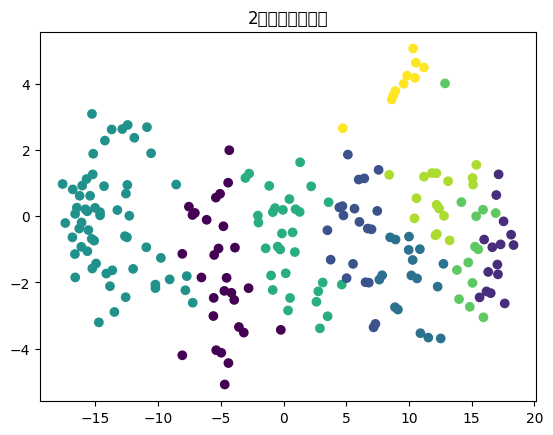

In [205]:
plt.scatter(vect_2d[:,0],vect_2d[:,1],c=export_div_by_country['km_label'])
plt.title('2维化参数聚类图')
plt.show()

In [206]:
export_div_by_country.query('km_label == 0').index

Int64Index([ 68,  92, 140, 148, 180, 222, 226, 234, 266, 328, 332, 340, 430,
            450, 462, 466, 478, 480, 524, 598, 646, 694, 706, 728, 768, 780,
            800, 834, 894],
           dtype='int64', name='Partner Code')

In [207]:
main.loc[main['Partner Code'].isin(export_div_by_country.query('km_label == 0').index.tolist()),'Region'].value_counts()

Western Africa     9871
Eastern Africa     6296
West Indies        4511
Central Africa     4355
South America      2686
South Asia         2521
Indian Ocean       1668
Central America    1441
Pacific            1081
Southern Africa     919
Northern Europe     649
Name: Region, dtype: int64

In [208]:
for i in export_div_by_country['km_label'].unique():
    print(main.loc[main['Partner Code'].isin(export_div_by_country.query('km_label == @i').index.tolist()),'Region'].value_counts().index[0])

South West Asia
South America
Western Africa
South America
Western Africa
South East Europe
South West Asia
Central Asia
Eastern Europe


In [223]:
for_plot = export_div_by_country.groupby('km_label').mean()
print(for_plot.index,for_plot.columns)
s = for_plot.values
fig = (
    HeatMap(opts.InitOpts(bg_color='white'))
    .add_xaxis(for_plot.index)
    .add_yaxis(
        '平均交易额',
        for_plot.columns,[[i, j, s.transpose()[i,j]] for i in for_plot.columns for j in for_plot.index],
        )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="HeatMap"),
        visualmap_opts=opts.VisualMapOpts(min_=s.min(),max_=s.max()),
    )
)
fig.render_notebook()

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='km_label') Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object', name='Commodity Code')


----

- 问题:
  - 关系不清晰